In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op

In [3]:
from sklearn.linear_model import Ridge

In [4]:
x = np.random.random((100,10))
y = np.dot(x, np.random.random(10))

In [5]:
model = Ridge(alpha=0.05)

In [7]:
model.fit(x,y)
y_pred = model.predict(x)

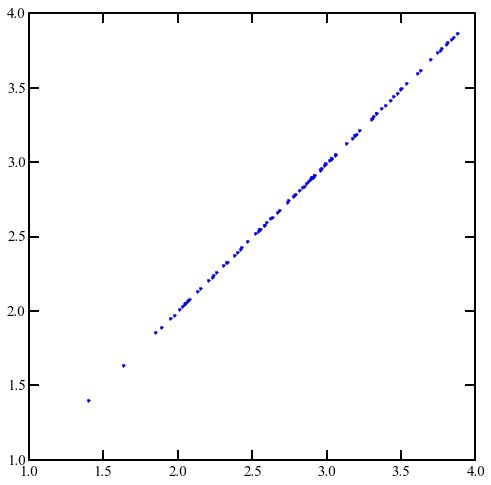

In [13]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(y,y_pred,'b.')

In [12]:
y.shape

(100,)

In [14]:
import emcee

In [46]:
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.fabs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [47]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [48]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [49]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [50]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [51]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [52]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [71]:
samples0 = sampler.run_mcmc(pos, 500)

In [55]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

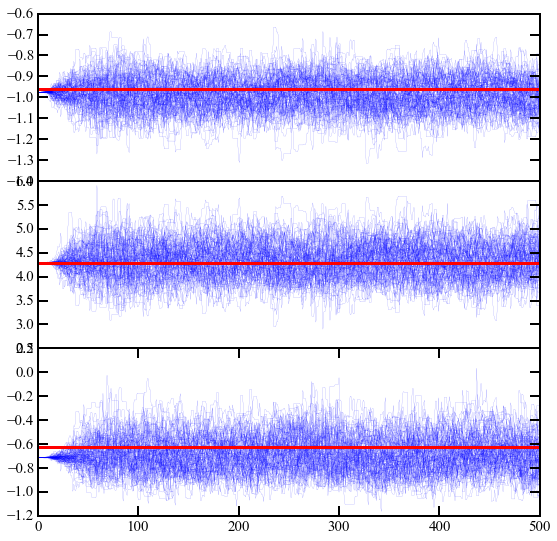

In [54]:
fig, axes = plt.subplots(3, 1, figsize=(9,9))
fig.subplots_adjust(hspace=0)
#for i, par in zip(np.arange(3), [m_true, b_true, f_true]):
for i, par, ax in zip(np.arange(3), [m_true, b_true, np.log(f_true)], axes):
    for j in np.arange(100):
        ax.plot(sampler.chain[j,:,i], 'b', linewidth=0.1)
    ax.plot([0,5E2], [par, par], 'r', linewidth=3)
for ax in axes[:-1]: 
    ax.get_xaxis().set_visible(False)

<Container object of 3 artists>

/Users/Benjamin/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


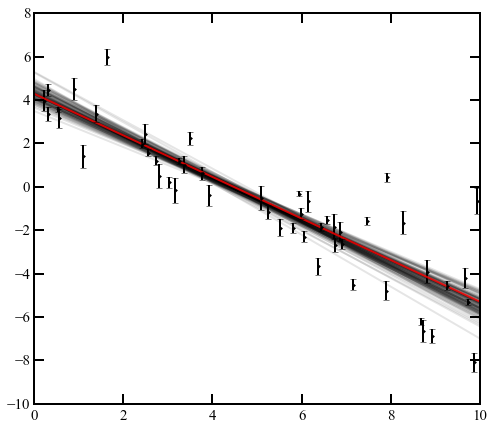

In [65]:
fig, ax = plt.subplots(1,1,figsize=(8,7))
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(xl, m*xl+b, color="k", alpha=0.1)
ax.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
ax.errorbar(x, y, yerr=yerr, fmt=".k")

In [69]:
len(pos[0])

3

In [70]:
result["x"]

array([-0.97567698,  4.28619297, -0.71207198])

In [73]:
sampler.chain.shape

(100, 1000, 3)